# SuchLinkedTrees

In the last article, we saw how to use `SuchTree` to probe the topology of
very large trees. In this article, we're going to look at the other component
of the package, `SuchLinkedTrees`.

If you are interested in studying how two groups of organisms interact (or, 
rather, have interacted over evolutionary time), you will find yourself with 
two trees of distinct groups of taxa that are linked by a matrix of 
interaction observations. This is sometimes called a 'dueling trees' problem.

![dueling trees](docs/dueling_trees.png)

If the trees happen to have the same number of taxa, and the interaction 
matrix happens to be a unit matrix, then you can compute the distance matrix
for each of your trees and use the 
[Mantel test](https://en.wikipedia.org/wiki/Mantel_test) to compare them. 
However, this is a pretty special case. Hommola *et al.* describe a method 
extends the Mantel test in this paper here :

* [A Permutation Test of Host–Parasite Cospeciation](http://dx.doi.org/10.1093/molbev/msp062). *Molecular Biology and Evolution*, Vol. 26, No. 7. (01 July 2009), pp. 1457-1468, by Kerstin Hommola, Judith E. Smith, Yang Qiu, Walter R. Gilks

This is implemented in `scikit-bio` as [`hommola_cospeciation`](http://scikit-bio.org/docs/latest/generated/generated/skbio.stats.evolve.hommola_cospeciation.html).
Unfortunately, the version in `scikit-bio` does not scale to very large trees,
and does not expose the computed distances for analysis. This is where 
`SuchLinkedTrees` can help.

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
import seaborn
import pandas
from scipy.cluster.hierarchy import ClusterWarning
from scipy.stats import pearsonr

warnings.simplefilter( 'ignore', UserWarning )

Populating the interactive namespace from numpy and matplotlib


To get started, we need to initialize two trees and a table of observations
linking the taxa on the two trees.

In [2]:
T1 = SuchTree( 'data/bigtrees/host.tree' )
T2 = SuchTree( 'data/bigtrees/guest.tree')
LK = pandas.read_csv( 'data/bigtrees/links.csv', index_col=0 )

print( 'host tree taxa     : %d' % T1.n_leafs )
print( 'guest tree taxa    : %d' % T2.n_leafs )
print( 'observation matrix : %d x %d' % LK.shape )

host tree taxa     : 14
guest tree taxa    : 103446
observation matrix : 14 x 103446


To create a `SuchLinkedTrees` instance, you need two `SuchTree`s and a pandas
DataFrame, where the taxa in the first tree matches the DataFrame index, and the
taxa in the second tree matches the DataFrame columns.

This is a pretty large dataset, so it takes a bit of time to load.

In [3]:
%time SLT = SuchLinkedTrees( T1, T2, LK )

CPU times: user 7min 28s, sys: 260 ms, total: 7min 28s
Wall time: 7min 29s


In [4]:
n_links = sum(LK.apply(sum))
print( 'total observations : %d' % n_links )
print( 'observation pairs  : %d' % int( ( n_links * ( n_links - 1 ) ) / 2 ) )

total observations : 44904
observation pairs  : 1008162156


To test for cospeciation, Hommola's method does the following :

* calculate the patristic distance between the host taxa from the two observations
* calculate the patristic distance between the guest taxa from the two observations
* calculate the Pearson's correlation of the distance measures

Then, to calculate the significance of the correlation, it randomly
permutes the observation table and recalculates the distances and correlations.
A significance measure (a $p$ value) is estimated based on how likely
the correlation measure on unpermuted observations could belong to the set 
of correlation measures on permuted observations.

For each correlation measure, we'd have to do calculate 1,008,162,156 patristic distances
through each of the two trees. To calculate the significance, we would then need to permute
the observations and then repeat the process about 50 times. That's 100,816,215,600 tree
traversals!

How long would that take? In our previous example, we benchmarked 1,000,000 distance
calculations at about 14 seconds on a single thread. For this dataset, one correlation
measure would require about a thousand times as many lookups, so it should have a run
time of about four hours. With the significance test, that would be a little more than
one CPU-week. I suppose that's not *impossible*, but for large datasets like this, we
probably don't need an exhaustive search of every possible pair of observations to get
a fairly accurate correlation measure.

So, we'ere going to use `SuchLinkedTrees.sample_linked_distances()`,
which returns a representative sample of distances. It does this
by filling a user-specified number of buckets (default : 64) with distances
between randomly chosen observations. It stops when the standard deviation of
the standard deviation of the buckets falls bellow `sigma` (default : 0.001).

In [5]:
%time result = SLT.sample_linked_distances( sigma=0.001, buckets=64, n=4096 )

CPU times: user 31 s, sys: 68 ms, total: 31 s
Wall time: 31.1 s


In [6]:
result

{'TreeA': array([0.33875802, 0.28075102, 0.37483799, ..., 0.39058605, 0.265522  ,
        0.29917303]),
 'TreeB': array([0.10008622, 0.38767058, 0.3411648 , ..., 0.28300837, 0.49306855,
        0.12877099]),
 'n_pairs': 1008162156,
 'n_samples': 2621440,
 'deviation_a': 0.000413960573496297,
 'deviation_b': 0.0009991885162889957}

In [7]:
print( 'sampled link pairs    : %d' % len(result['TreeA']) )
print( 'Pearson\'s correlation : r=%f, p=%f' % pearsonr( result['TreeA'],
                                                         result['TreeB'] ) )

sampled link pairs    : 2621440
Pearson's correlation : r=0.017602, p=0.000000


Not too bad. The algorithm went through ten iterations, placing ten blocks of
4096 pairs into each bucket before it converged on our stopping condition after
testing 2,621,440 pairs (about 0.2% of the possible pairs). Note that the 
$p$-value we see here is not Hommola's $p$-value -- it doesn't include any
information about the topologies of the trees.

Let's see what the distribution of sampled distances looks like.

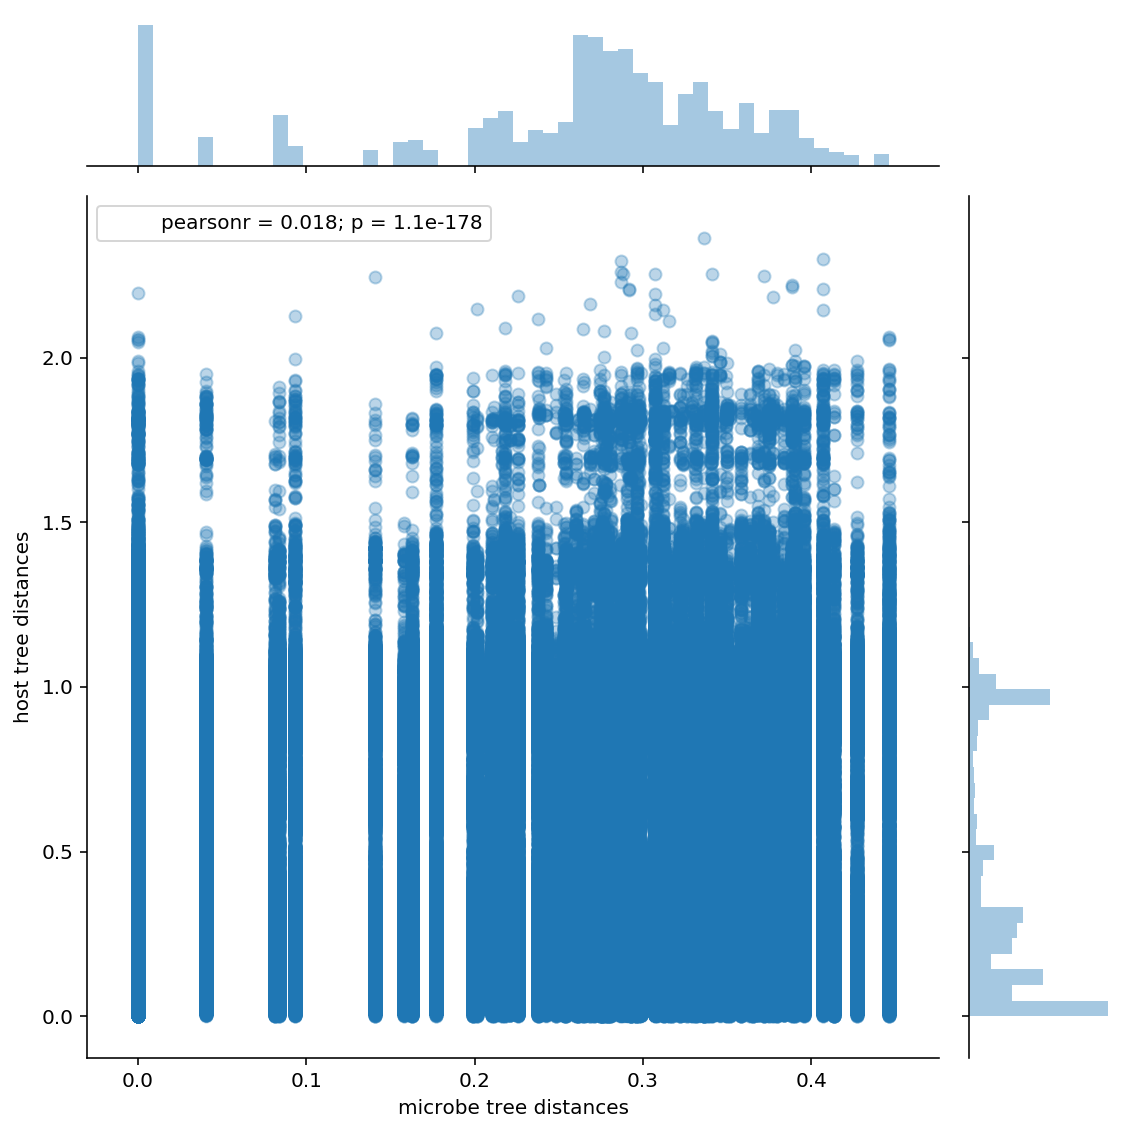

In [8]:
df = pandas.DataFrame( { 'microbe tree distances' : result['TreeA'], 
                         'host tree distances'    : result['TreeB'] } )

seaborn.jointplot( 'microbe tree distances', 'host tree distances',
                   data=df, alpha=0.3, size=8 )

Well... that's... something? In this case, we are looking at the entire microbiome
of a complex of 14 host species that's about 10-20 million years old. Because
bacteria and archaea are older than that, we don't expect to see a meaningful
pattern of coevolution at the scale of the whole microbial community.

If we're looking for coevolution, we want to examine clades within the microbial
community. This is what `SuchLinkedTrees` really designed to do.

`SuchLinkedTrees` has two functions that allow you to examine individual clades.
`subset_a()` takes the node id of an internal node of the first tree (usually, the
host organisms), and masks the data within the `SuchLinkedTrees` instance so that
that node behaves as the root. `subset_b()` does the same for the second tree 
(usually, the guest organisms).

In [9]:
SLT.subset_b_size

103446

The observations are also masked so that distance calculations are constrained to within that
clade. The masking operation is extremely efficient, even for very large datasets.

In [10]:
SLT.subset_b(121)
SLT.subset_b_leafs

array([122, 124,   6,   4,   0,   2,  18, 118, 120,   8,  14,  16,  10,
        12,  32,  34, 116,  26,  28,  30,  36,  86, 102, 104, 110, 112,
       114,  24,  38,  40,  84,  88,  90,  92,  94, 100, 106, 108,  20,
        22,  42,  44,  78,  96,  98,  76,  80,  82,  52,  70,  46,  72,
        74,  48,  50,  54,  56,  58,  60,  62,  64,  66,  68])

So, all we need to do is iterate over the internal nodes of the microbe tree
(which we can get from `SuchTree`'s `get_internal_nodes()` function), subset
the guest tree to that node, and apply Hommola's algorithm to the masked 
`SuchLinkedTrees` instance.

I'm going to put some simple constrains based on clade size. You could also
use the average or total tree depth for each clade. It takes about an hour
to finish all 103,445 clades, so let's look at a random sample of 10,000 of
them.

In [11]:
from pyprind import ProgBar

warnings.simplefilter( 'ignore', RuntimeWarning )

N = len( T2.get_internal_nodes() )
progbar = ProgBar( N, title='Chugging through microbime data...' )

data = []
for n,nodeid in enumerate( T2.get_internal_nodes() ) :
    
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_b_size < 10 :
        continue
    if SLT.subset_n_links > 2500 :
        continue

    d = {}
    d['name']    = 'clade_' + str(nodeid)
    d['n_links'] = SLT.subset_n_links
    d['n_leafs'] = SLT.subset_b_size
    
    ld = SLT.linked_distances()
    
    d['r'], d['p'] = pearsonr( ld['TreeA'], ld['TreeB'] ) 
    
    data.append( d )

data = pandas.DataFrame( data ).dropna()

Chugging through microbime data...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:00:34


Let's see what we've got!

In [12]:
data.head()

,n_leafs,n_links,name,p,r
0,105,46,clade_125,2.459121e-04,-0.113734
1,319,123,clade_159421,1.014772e-03,-0.037933
2,63,18,clade_121,8.836506e-02,-0.138239
3,42,28,clade_127,1.432212e-02,-0.125883
4,242,87,clade_158329,1.748205e-07,-0.085288


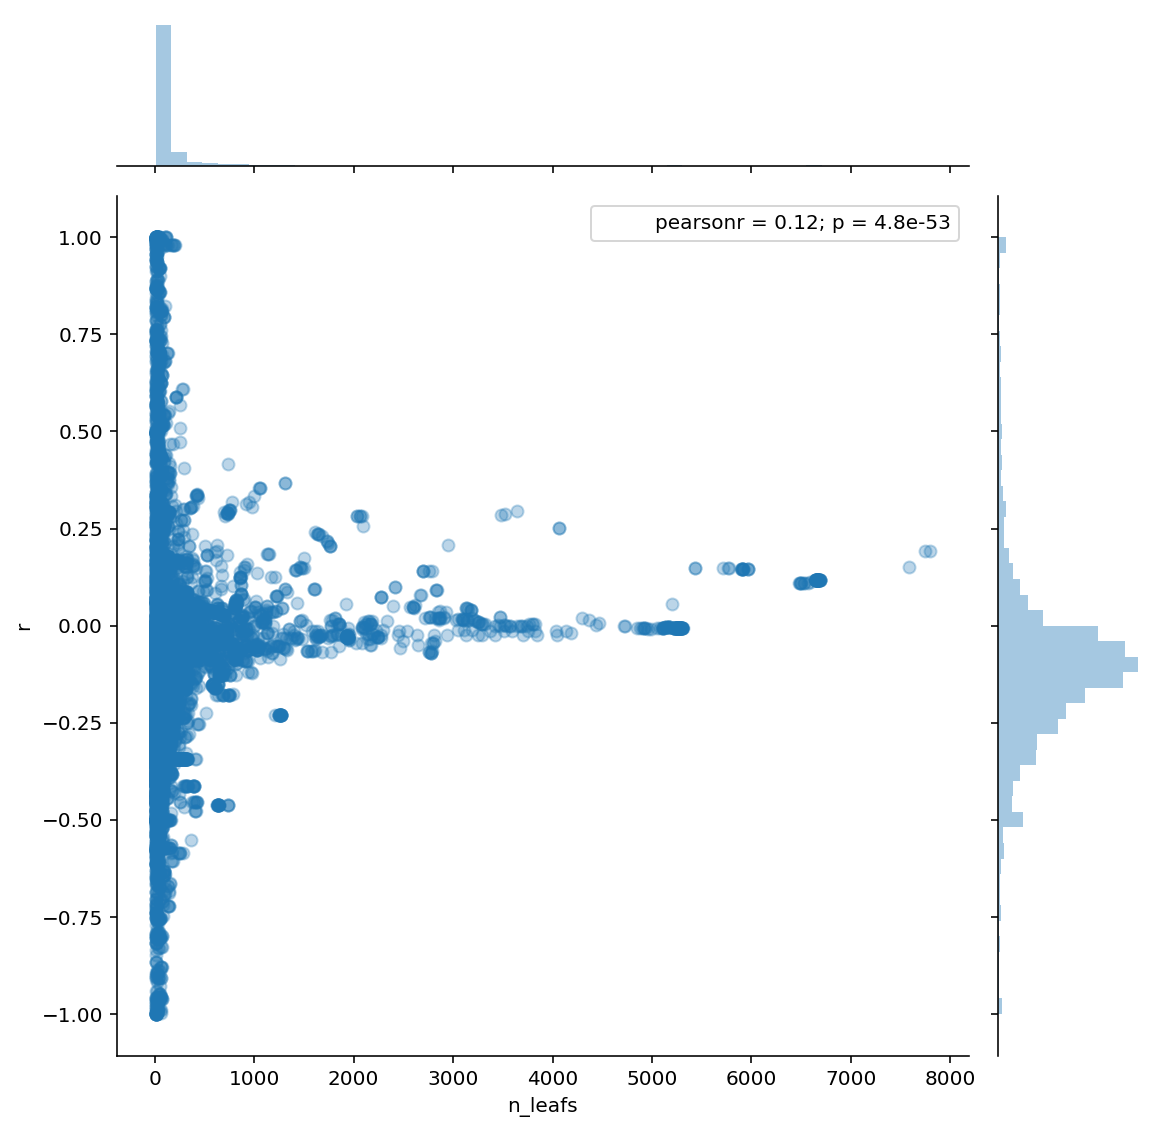

In [13]:
seaborn.jointplot( data.n_leafs, data.r, alpha=0.3, size=8 )

Are there any clades that are big enough to to be interesting that
show a significant correlation above 0.6?

In [14]:
data.loc[ ( data.r > 0.6      ) &
          ( data.n_leafs > 10 ) &
          ( data.n_links > 15 ) &
          ( data.p < 0.01     ) ]

,n_leafs,n_links,name,p,r
14799,108,22,clade_26971,5.982235e-33,0.681951
14999,103,22,clade_27163,5.982235e-33,0.681951
15196,96,20,clade_27145,3.844922e-27,0.680072
15395,87,17,clade_27061,1.621913e-19,0.676366


Cool. Let's go back and look at these in more detail.

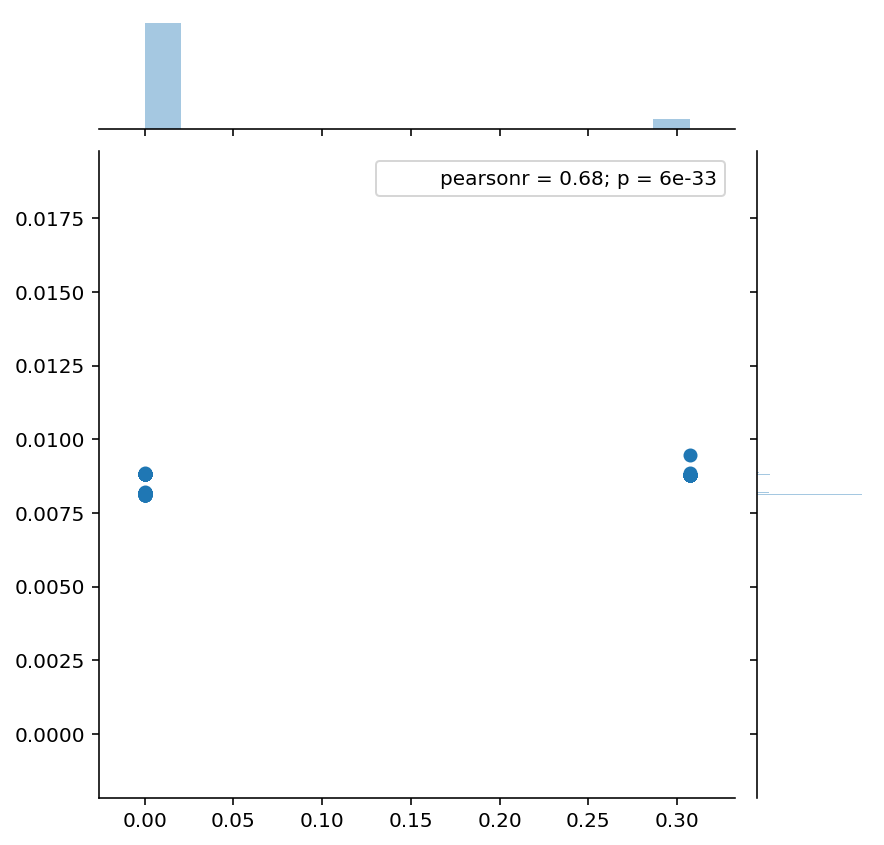

In [15]:
SLT.subset_b( 26971 )

ld = SLT.linked_distances()

seaborn.jointplot( ld['TreeA'], ld['TreeB'] )

Huh. Well, that looks a lot less interesting than I hoped. This is the
problem with correlation measures -- they don't test that the data obeys
their assumptions. In this case, we're using Pierson's $r$, which
assumes that the data from the two sources is normally distributed, which
this clearly is not. If you haven't seen this before, check out
[Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet);
the gist of his argument is that it's not a good idea to apply any statistic
without examining the data graphically.

Let's have a look at the trees so we can get a better idea of why this is
broken. Unfortunately, I don't have a great way of pulling out the subtree
for plotting yet, so this will require some help from `dendropy`.

In [16]:
from dendropy import Tree
from tempfile import NamedTemporaryFile

tmpfile1 = NamedTemporaryFile()
tmpfile2 = NamedTemporaryFile()

# invert the taxa : node_id map
# FIXME : I need a better interface for this, suggestions welcome

sfeal = dict( zip( SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )

subset_taxa = [ sfeal[i] for i in SLT.subset_b_leafs ]

guest_tree = Tree.get_from_path( 'data/bigtrees/guest.tree',
                                 schema='newick',
                                 preserve_underscores=True ) # Newick is the worst

subset_tree = guest_tree.extract_tree_with_taxa_labels( subset_taxa )
subset_tree.write_to_path( tmpfile1.name, schema='newick' )

LK[ subset_taxa ].to_csv( tmpfile2.name )

In [17]:
%load_ext rpy2.ipython

cladepath = tmpfile1.name
linkpath = tmpfile2.name

outpath = clade_26971.svg

NameError: name 'clade_26971' is not defined

In [ ]:
%%R -i cladepath -i linkpath -i outpath -w 800 -h 800 -u px

library("phytools")
library("igraph")

tr1 <- read.tree( "data/bigtrees/host.tree" )
tr2 <- read.tree( cladepath )
links <- read.csv( linkpath, row.names=1, stringsAsFactors = F )
im <- graph_from_incidence_matrix( as.matrix( links ) )
assoc <- as_edgelist( im )
obj <- cophylo( tr1, tr2, assoc=assoc )
#svg( figpath, width = 10, height = 12 )
svg( "foobar.svg" )
plot( obj )

Now that we've gotten through the plotting hampsterdance, we can have a look at the
structure of this clade and its relationship with the host organisms :

<img src=clade_26971.svg width=500>

If we're hoping to find an example of coevolution, this is an excellent example of
what we are not looking for! The Hommola test is not really appropriate for this
application. The Hommola test is really intended for cases where you have something
that looks like it might be an example of coevolution, and you would like to measure
how strong the effect is. We are abusing it somewhat by asking it to distinguish
coevolution from a background of other kinds of interactions, to say nothing of ignoring
multiple testing effects.

So, we'll need a more sophisticated way to test for coevolution. With `SuchTree` and
`SuchLinkedTrees` handling the grunt work, we can focus on the those models.